In [30]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns

In [2]:
news_dija_data = pd.read_csv('combined_stock_data.csv')
djia_data = pd.read_csv('upload_DJIA_table.csv')

In [3]:
# clean null rows
news_dija_data = news_dija_data.dropna()

# convert all rows to strings
news_dija_data = news_dija_data.apply(lambda x: x.map(lambda y: str(y)), axis=1) 

# remove b characters
news_dija_data = news_dija_data.apply(lambda x: x.map(lambda y: y.replace('b"', '').replace
                                                      ("b'", '').replace('"', '')), axis=1)

In [4]:
train = news_dija_data[news_dija_data['Date'] < '2015-01-01']
test = news_dija_data[news_dija_data['Date'] > '2014-12-31']

In [5]:
trainingheadlines = []
for row in range(0,len(train.index)):
    trainingheadlines.append(' '.join(str(x) for x in train.iloc[row,2:27]))

In [6]:
initialvectorizer = CountVectorizer()
initialtrain = initialvectorizer.fit_transform(trainingheadlines)
print(initialtrain.shape)

(1608, 31114)


In [7]:
initialmodel = LogisticRegression()
initialmodel = initialmodel.fit(initialtrain, train["Label"])

/Users/cristinalawson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [8]:
testingheadlines = []
for row in range(0,len(test.index)):
    testingheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
initialtest = initialvectorizer.transform(testingheadlines)
initialpredictions = initialmodel.predict(initialtest)

378


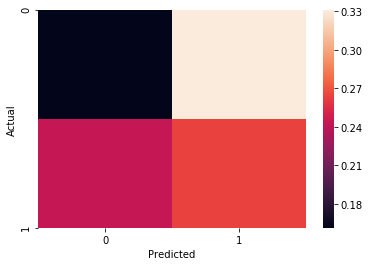

In [9]:
counts = pd.crosstab(test["Label"], initialpredictions, rownames=["Actual"], colnames=["Predicted"])
counts
print(counts.sum().sum())
joint = counts / counts.sum().sum()
joint
sns.heatmap(joint)

In [10]:
initialwords = initialvectorizer.get_feature_names()
initialcoeffs = initialmodel.coef_.tolist()[0]
coeffs_df = pd.DataFrame({'Word' : initialwords,'Coefficient' : initialcoeffs})
coeffs_df = coeffs_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
coeffs_df.head(10)

,Word,Coefficient
15582,kills,0.528035
25859,so,0.475022
28772,tv,0.462943
19071,nigeria,0.449722
28742,turn,0.415155
15734,korea,0.413472
19773,olympics,0.410356
27778,territory,0.401286
24819,self,0.399448
28608,troops,0.396639


In [11]:
coeffs_df.tail(10)

,Word,Coefficient
6585,congo,-0.436430
26817,students,-0.439945
26158,speech,-0.449215
16662,low,-0.449539
24324,sanctions,-0.491120
24113,run,-0.504891
7036,country,-0.514576
24988,sex,-0.519301
24681,sea,-0.521224
3596,begin,-0.532128


In [12]:
combined_df = news_dija_data[['Date', 'Label', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']].merge(
    djia_data, how='inner', on='Date', left_index=True)

In [13]:
columns = list(combined_df)
columns.append(columns.pop(columns.index('Label')))
combined_df = combined_df.loc[:, columns]
combined_df.head()

,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
1988,2008-08-08,75.0,25.0,18.75,56.25,25.0,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0
1987,2008-08-11,83.3333333333,16.6666666667,41.6666666667,41.6666666667,16.6666666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1
1986,2008-08-12,56.25,43.75,18.75,37.5,43.75,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0
1985,2008-08-13,38.4615384615,61.5384615385,15.3846153846,23.0769230769,61.5384615385,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,0
1984,2008-08-14,45.4545454545,54.5454545455,36.3636363636,9.090909090910001,54.5454545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,1


In [14]:
combined_df['Volume'] = combined_df['Volume'].astype(float)
combined_df['Subjectivity'] = combined_df['Subjectivity'].astype(float)
combined_df['Objectivity'] = combined_df['Objectivity'].astype(float)
combined_df['Positive'] = combined_df['Positive'].astype(float)
combined_df['Negative'] = combined_df['Negative'].astype(float)
combined_df['Neutral'] = combined_df['Neutral'].astype(float)
combined_df['Label'] = combined_df['Label'].astype(float)

combined_df.index = combined_df.index.sort_values()
combined_df.head()

,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
0,2008-08-08,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000.0,11734.320312,0.0
1,2008-08-11,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000.0,11782.349609,1.0
2,2008-08-12,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000.0,11642.469727,0.0
3,2008-08-13,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000.0,11532.959961,0.0
4,2008-08-14,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000.0,11615.929688,1.0


In [15]:
list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']

for col in list:
    combined_df[col] = combined_df[col].fillna(combined_df[col].mean())

In [16]:
X = combined_df.loc[:,'Subjectivity':'Adj Close']
y = combined_df.loc[:,'Label']

In [17]:
validation_size = 0.35
trainSize = int(len(X.index) * 0.7)

In [24]:
X_train = X.loc[0:trainSize, :] 
X_test = X.loc[trainSize: len(X.index), :]
y_train = y[0:trainSize]
y_test = y.loc[trainSize: len(X.index)]

## Logistic Regression

In [26]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('LogisticRegression' + ": " + str(score))

LogisticRegression: 0.5294117647058824


/Users/cristinalawson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



## K-Nearest Neighbor

In [27]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('KNeighborsClassifier' + ": " + str(score))

KNeighborsClassifier: 0.4588235294117647


## Random Forest Classifier

In [28]:
model = RandomForestClassifier(n_estimators=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('RandomForestClassifier' + ": " + str(score))

RandomForestClassifier: 0.5596638655462185


## SGD(Stochastic Gradient Descent) Classifier

In [29]:
model = SGDClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('SGDClassifier' + ": " + str(score))

SGDClassifier: 0.47058823529411764
